In [17]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import plotly.express as px
import plotly.graph_objects as go
import datetime as dt

In [32]:


stock_data = yf.download('AAPL', start='2021-01-01', end='2023-07-01')
print(stock_data.shape)
stock_data.tail()



[*********************100%***********************]  1 of 1 completed
(627, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-26,186.830002,188.050003,185.229996,185.270004,185.270004,48088700
2023-06-27,185.889999,188.389999,185.669998,188.059998,188.059998,50730800
2023-06-28,187.929993,189.899994,187.600006,189.250000,189.250000,51216800
2023-06-29,189.080002,190.070007,188.940002,189.589996,189.589996,46347300
2023-06-30,191.630005,194.479996,191.259995,193.970001,193.970001,85069600


In [33]:


fig = px.line(stock_data,  y="Close", title='Stock price chart')
fig.show()



In [34]:


close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))



In [35]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [36]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 25)                2525      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
442/442 [==============================] - 11s 18ms/step - loss: 0.0085
Epoch 2/3
442/442 [==============================] - 8s 19ms/step - loss: 0.0037
Epoch 3/3
442/442 [==============================] - 9s 20ms/step - loss: 0.0034


In [38]:


predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse



4/4 [==============================] - 1s 13ms/step


4.169755493164063

In [39]:


data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
train.reset_index(inplace = True)
validation.reset_index(inplace = True)



C:\Users\HerbyHerb\AppData\Local\Temp\ipykernel_15976\198658209.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [40]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.Date, y=train.Close, mode='lines', name='Actual Price'))
fig.add_trace(go.Scatter(x=validation.Date, y=validation.Close, mode='lines', name='Actual Price'))
fig.add_trace(go.Scatter(x=validation.Date, y=validation.Predictions, mode='lines', name='Predicted price'))
fig.update_layout(
        title="Time series Forecasting using LSTM",
        xaxis_title="Date-Time",
        yaxis_title="Values",
        legend_title="Legend",
)
fig.show()

In [42]:
# Erzeugen Sie ein neues Array, das die letzten 60 Tage des originalen 'Close'-Daten-Arrays enthält
new_data = scaled_data[len(scaled_data) - 60:, :]

# Speichern Sie das Array in x_input
x_input = new_data

# Skalieren Sie x_input zurück in den ursprünglichen Zahlenbereich
x_input = scaler.inverse_transform(x_input)

# Erzeugen Sie ein leeres Array, um die Vorhersagen zu speichern
predictions = []

# Nutzen Sie eine for-Schleife, um die Vorhersagen für die nächsten 30 Tage zu generieren
for i in range(30):
    
    # Skalieren Sie x_input zurück und formen Sie es um
    x_input_scaled = scaler.transform(x_input.reshape(-1, 1))
    
    # Formen Sie x_input_scaled um, damit es den Eingabeformat-Anforderungen des Modells entspricht
    x_input_reshaped = np.reshape(x_input_scaled, (1, x_input_scaled.shape[0], 1))
    
    # Erstellen Sie die Vorhersage mit dem Modell
    prediction = model.predict(x_input_reshaped)
    
    # Skalieren Sie die Vorhersage zurück in den ursprünglichen Zahlenbereich
    prediction = scaler.inverse_transform(prediction)
    
    # Fügen Sie die Vorhersage zum 'predictions'-Array hinzu
    predictions.append(prediction[0,0])
    
    # Fügen Sie die Vorhersage zum 'x_input'-Array hinzu und entfernen Sie den ältesten Wert in 'x_input'
    x_input = np.append(x_input, prediction)
    x_input = np.delete(x_input, 0)
    x_input = x_input.reshape(-1, 1)

# Erstellen Sie ein Datums-Array für die nächsten 30 Tage
next_30_days = pd.date_range(start=stock_data.index[-1]+pd.DateOffset(1), periods=30, freq='B')

# Erstellen Sie einen Dataframe mit den Vorhersagen
predictions_df = pd.DataFrame(predictions, index=next_30_days, columns=['Predictions'])

# Fügen Sie die Vorhersagen zum originalen Dataframe hinzu
stock_data_extended = pd.concat([stock_data, predictions_df], axis=0)

# Setzen Sie den Index zurück, um das Datum als Spalte hinzuzufügen
stock_data_extended.reset_index(inplace=True)

# Benennen Sie die 'index'-Spalte in 'Date' um
stock_data_extended.rename(columns={'index': 'Date'}, inplace=True)


1/1 [==============================] - 0s 20ms/step


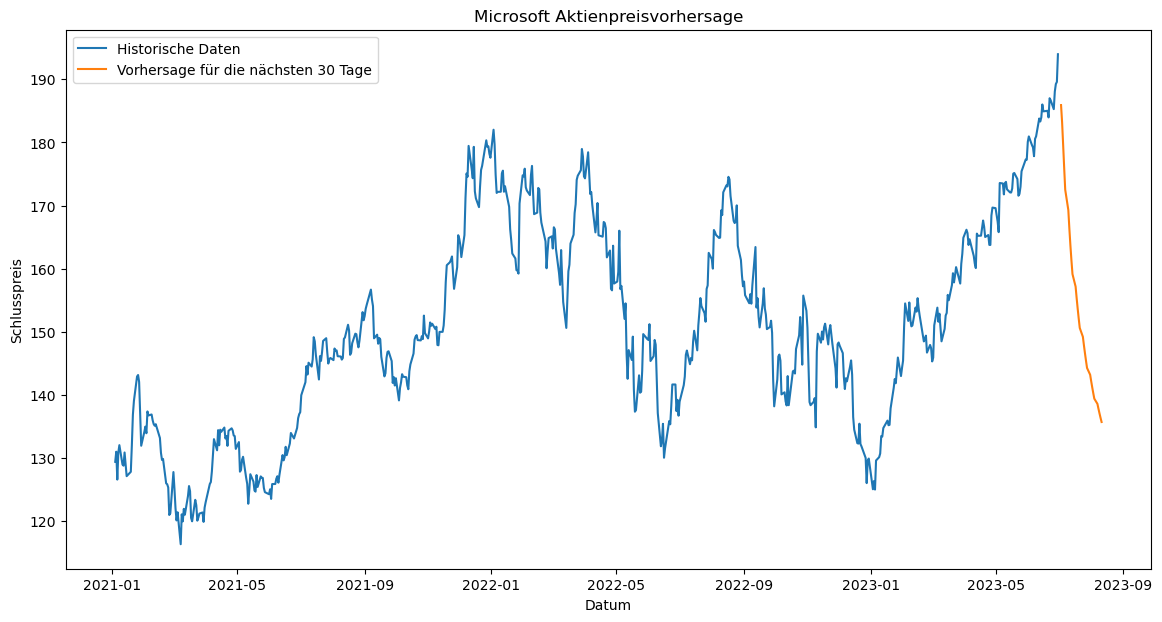

In [43]:
import matplotlib.pyplot as plt

# Erstellen Sie eine neue Figur
plt.figure(figsize=(14,7))

# Plotten Sie die historischen Daten
plt.plot(stock_data_extended['Date'][:len(stock_data)], stock_data_extended['Close'][:len(stock_data)], label='Historische Daten')

# Plotten Sie die Vorhersagen
plt.plot(stock_data_extended['Date'][len(stock_data):], stock_data_extended['Predictions'][len(stock_data):], label='Vorhersage für die nächsten 30 Tage')

# Fügen Sie Titel und Labels hinzu
plt.title('Microsoft Aktienpreisvorhersage')
plt.xlabel('Datum')
plt.ylabel('Schlusspreis')
plt.legend(loc='upper left')

# Zeigen Sie das Diagramm an
plt.show()

